# GD3: CAM, Grad-CAM

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. CAM, Grad-CAM용 모델 준비하기

In [3]:
'''
(1) 데이터셋 로드
'''
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})
ds size: 744.72 MiB
ds_train: tf.Tensor(12000, shape=(), dtype=int64)
ds_test: tf.Tensor(8580, shape=(), dtype=int64)


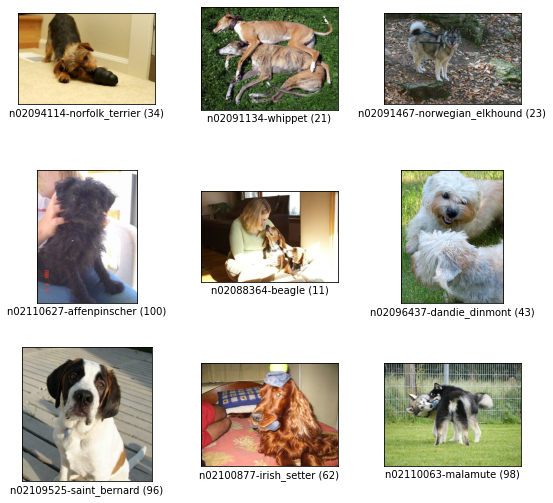

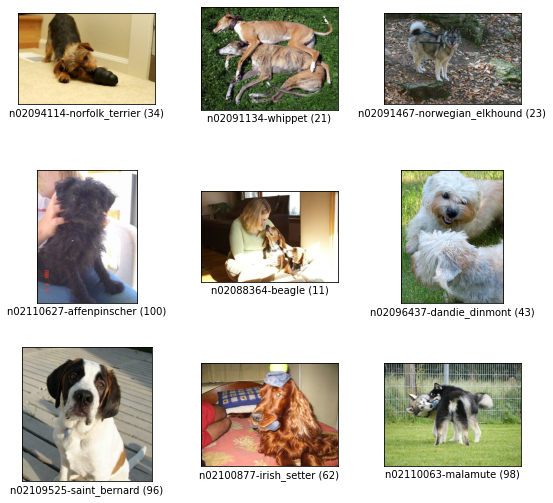

In [4]:
#데이터셋 확인
print(ds_info.features)
print('ds size:', ds_info.dataset_size)
print('ds_train:',tf.data.experimental.cardinality(ds_train))
print('ds_test:',tf.data.experimental.cardinality(ds_test))
tfds.show_examples(ds_train, ds_info)
# tfds.show_examples(ds_test, ds_info)

In [5]:
'''
(2)데이터 전처리
'''
NUM_CLASS=120
IMG_SIZE = 224
BATCH_SIZE = 16
# num_classes = ds_info.features["label"].num_classes


def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [IMG_SIZE, IMG_SIZE])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label'] #bbox 제외(CAM에서는 전체영역 학습)

def apply_normalize_on_dataset(ds, is_test=False, BATCH_SIZE=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=4
    )
    ds = ds.batch(BATCH_SIZE)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [13]:
'''
(3)모델 정의
'''
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='avg',      # GAP를 적용
)
x = base_model.output
outputs = keras.layers.Dense(NUM_CLASS, activation='softmax')(x)

'''
GAP의 장점:

1. Location 정보를 FC Layer보다 적게 잃는다.
2. 파라미터를 차지하지 않아 계산 속도가 빠르다.
3. 마찬가지로 파라미터가 많아지지 않기 때문에 오버피팅을 방지한다.
4. feature map 안의 값들의 평균을 사용하기 때문에 global context 정보를 가진다.
'''

cam_model = keras.Model(inputs=base_model.input, outputs=outputs)
cam_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_____________________________

In [16]:
'''
(4)모델 학습
    어느정도 학습을 진행해보고 CAM을 확인해보자
'''
is_train = False

cam_model.compile(
loss='sparse_categorical_crossentropy',
optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
metrics=['accuracy'],
)

if is_train == True:
    history_cam_model = cam_model.fit(
        ds_train_norm,
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=20,
        validation_data=ds_val_norm,
        verbose=1,
        use_multiprocessing=True,
    )

    cam_model.save('./aiffel/class_activation_map/cam_model')

Epoch 1/20
750/750 [==============================] - 182s 222ms/step - loss: 2.2266 - accuracy: 0.4378 - val_loss: 3.3978 - val_accuracy: 0.1927
Epoch 2/20
750/750 [==============================] - 162s 216ms/step - loss: 0.7963 - accuracy: 0.7795 - val_loss: 1.0658 - val_accuracy: 0.6849
Epoch 3/20
750/750 [==============================] - 161s 215ms/step - loss: 0.2712 - accuracy: 0.9383 - val_loss: 0.9804 - val_accuracy: 0.7165
Epoch 4/20
750/750 [==============================] - 160s 213ms/step - loss: 0.0802 - accuracy: 0.9900 - val_loss: 0.9357 - val_accuracy: 0.7310
Epoch 5/20
750/750 [==============================] - 160s 213ms/step - loss: 0.0366 - accuracy: 0.9981 - val_loss: 0.9083 - val_accuracy: 0.7379
Epoch 6/20
750/750 [==============================] - 162s 215ms/step - loss: 0.0229 - accuracy: 0.9985 - val_loss: 0.9302 - val_accuracy: 0.7404
Epoch 7/20
750/750 [==============================] - 161s 215ms/step - loss: 0.0157 - accuracy: 0.9993 - val_loss: 0.9494 -

INFO:tensorflow:Assets written to: ./aiffel/class_activation_map/cam_model/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


- model.save(), keras h5 차이
    - saved_model.pb파일에는 모델 구성 및 Optimizer, loss, metric 가 저장되고, variables 폴더에는 가중치가 저장됩니다.  
    - my_model  폴더 대신 하나의  my_model.h5파일로 저장됩니다. SavedModel형식 대비해서 model.add_loss()와  model.add_metric()에 의해서 추가된 손실 및 메트릭은 저장되지 않습니다. 

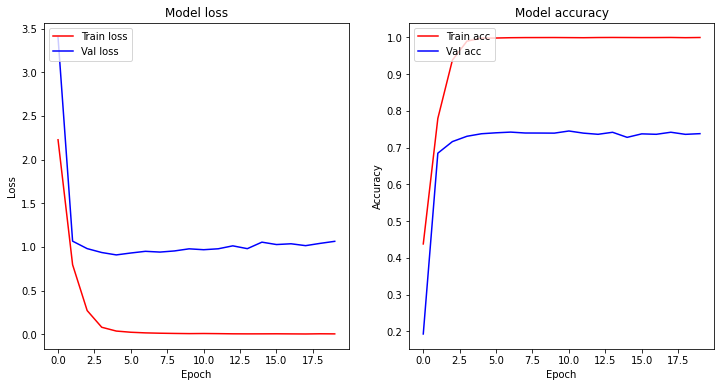

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_cam_model.history['loss'], 'r')
ax1.plot(history_cam_model.history['val_loss'], 'b')
# ax1.set_ylim([0.00, 0.05])
ax1.set_title('Model loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['Train loss', 'Val loss'], loc='upper left')

ax2.plot(history_cam_model.history['accuracy'], 'r')
ax2.plot(history_cam_model.history['val_accuracy'], 'b')
# ax2.set_ylim([0.98, 1])
ax2.set_title('Model accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train acc', 'Val acc'], loc='upper left')

plt.show()

- ResNet을 fine-tuning한 결과, 0.7초반대의 정확도를 보인다.
> 논문 참조:   
 "우리는 대부분의 경우에 추가 레이어를 제거할 때 1~2%의 성능 저하가 있는 것을 발견했습니다. 따라서, 우리는 전반적으로 GAP 네트워크에서 분류 성능이 크게 유지되는 것을 발견했습니다. 분류 성능이 좋은 네트워크는 객체의 범주와 경계 상자 위치를 정확하게 식별하는 것이 필요한 로컬라이제이션 작업에서 높은 성능을 달성하기 위해 중요합니다."

## 2. CAM, Grad-CAM 구현

dict_keys(['image', 'image/filename', 'label', 'objects'])
(325, 500, 3)
71 ()


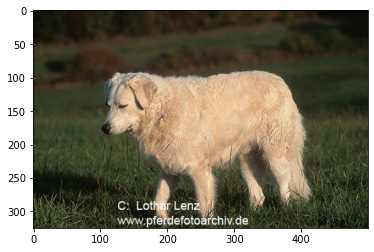

In [10]:
'''
(1)샘플 가져오기
'''
def get_one(ds):
    ds.shuffle(1000) #랜덤으로 가져오게 셔플
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)
print(item.keys())
print(item['image'].shape)
print(item['label'],item['label'].shape)
plt.imshow(item['image'])
plt.show()

In [18]:
'''
(2)모델 예측 확인
'''
cam_model = keras.models.load_model('./aiffel/class_activation_map/cam_model') 

sample_item = item.copy()
item_img_tensor, item_class_idx = normalize_and_resize_img(sample_item)
item_pred = cam_model.predict(tf.expand_dims(item_img_tensor,0))
top5_indices = np.argsort(item_pred)[0][-5:]  # 상위 5개 값에 해당하는 인덱스
top5_values = item_pred[0][top5_indices]  # 상위 5개 값
# print(item_pred)
print("Top5 values:", top5_values,4)
print("Top5 idx:", top5_indices)
print('Real idx:',item_class_idx)

Top5 values: [8.8507230e-05 1.0249252e-04 1.2773466e-02 2.1638630e-02 9.6502900e-01] 4
Top5 idx: [103  19 105  56  71]
Real idx: 71


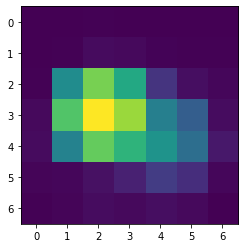

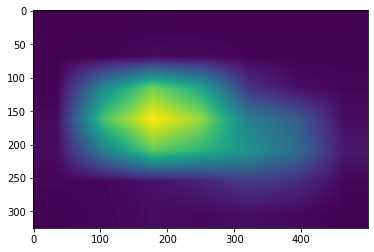

In [19]:
'''
(3)CAM 구현
'''
cam_model = tf.keras.models.load_model('./aiffel/class_activation_map/cam_model')

def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item) #(224, 224, 3),()
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.Model([model.inputs], #(1, 224, 224, 3)
                               [model.layers[-3].output, model.output])#(1, 7, 7, 2048),(1, 120)
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) #img_tensor에 배치차원 추가
    conv_outputs = conv_outputs[0, :, :, :] #(7, 7, 2048)
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] #(2048,120)
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) #(7,7)
    
    for i, w in enumerate(class_weights[:, class_idx]):#(2048,120)에서 class_idx에 해당하는 weights선택
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]# (i번째 채널의 weights)*(i번째 채널의 7x7 conv_outputs), 채널 수 만큼(2048번) 반복

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy() #(7,7)
    plt.imshow(cam_image)
    plt.show()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

질문 :    
    ```
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))   
    ```   
    predictions는 안써도 되는거 아닌지?   
        - Grad-CAM에서는 쓰이기 때문에 이런식으로 정의하는 것 같다.   
    CAM에서 그리드 패턴 나오는 이유?   
        - resize 과정에서 생기는 것 같다.   


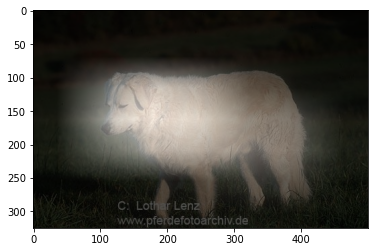

In [20]:
'''
(4)CAM과 이미지 합치기
'''
def visualize_cam_on_image(cam_image, item, alpha=0.7):
    beta = (1.0 - alpha)
    item = copy.deepcopy(item)
    cam_image = copy.deepcopy(cam_image)
    origin_image = item['image'].astype(np.uint8)
    cam_image_3channel = np.stack([cam_image*255]*3, axis=-1)
    cam_image_3channel = np.where(cam_image_3channel < 0, 0, cam_image_3channel) #음수값이 255로 바껴서 0으로
    cam_image_3channel = cam_image_3channel.astype(np.uint8)
    merged_image = cv2.addWeighted(cam_image_3channel, alpha, origin_image, beta, 0.0)
    return merged_image

blended_image = visualize_cam_on_image(cam_image, item)
plt.imshow(blended_image)
plt.show()

Model input: (1, 224, 224, 3)
Model output: (1, 7, 7, 2048) (1, 120)
Weights: (2048,)
CAM: (7, 7)


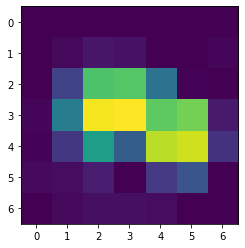

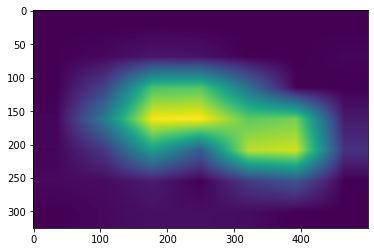

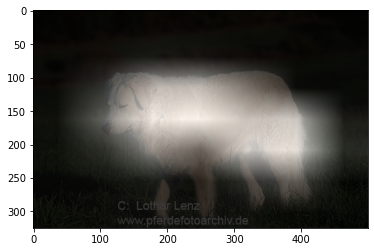

In [21]:
'''
(5)Grad-CAM 구현
'''
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다..
    grad_model = tf.keras.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    #activation_layer output:(1, f, f, c), model output:(1, 120)
    
    # 원하는 class에 따른 layer_output의 gradient를 구함
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0)) #(1, f, f, c),(1, 120)
        print('Model input:', tf.expand_dims(img_tensor, 0).shape)
        print('Model output:',conv_output.shape, pred.shape)
        loss = pred[:, class_idx] #  class 예측값 (1,)
        output = conv_output[0] #  layer의 output (f,f,c)
        grad_val = tape.gradient(loss, conv_output)[0] #  (f,f,c)

    # gradient의 GAP으로 weight를 구함     
    weights = np.mean(grad_val, axis=(0, 1)) 
    print('Weights:',weights.shape) #(c,)
    
    # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2]) 
    for k, w in enumerate(weights):
        grad_cam_image += w * output[:, :, k]    
    print('CAM:',grad_cam_image.shape) #(f,f)   
    
    grad_cam_image = tf.math.maximum(0, grad_cam_image) #relu 적용, CAM은 이게 없어서 음수값이 잡혔음
    grad_cam_image /= np.max(grad_cam_image) #normalize
    # 이미지 출력
    grad_cam_image = grad_cam_image.numpy() 
    plt.imshow(grad_cam_image)
    plt.show()
    
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
'''
(6)Guided-CAM 구현 : 에러가 나는중
#     guided_grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2]) #(f,f)
#     #Guided CAM : relu
#     guided_grads = tf.cast(conv_output > 0, 'float32') * tf.cast(grad_val > 0, 'float32') * grad_val
#     guided_grad_cam = guided_grad_cam_image * tf.expand_dims(grad_cam_image, -1) #(f,f,c)(f,f,1)
# #     guided_grad_cam = guided_grads * grad_cam_image[..., np.newaxis]
#     print(guided_grads.shape[0],(tf.expand_dims(grad_cam_image, -1)).shape, guided_grad_cam.shape) 
#     plt.imshow(guided_grad_cam)
#     plt.show()
'''
    return grad_cam_image

grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

#Grad_CAM + image
blended_image = visualize_cam_on_image(grad_cam_image, item, alpha=0.8)
plt.imshow(blended_image)
plt.show()

Model input: (1, 224, 224, 3)
Model output: (1, 14, 14, 1024) (1, 120)
Weights: (1024,)
CAM: (14, 14)


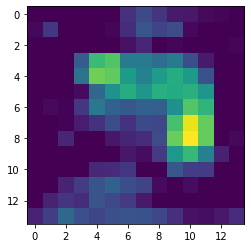

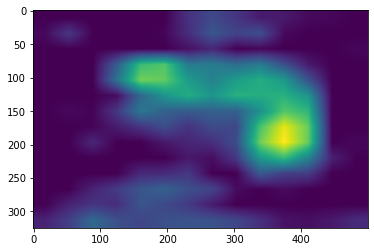

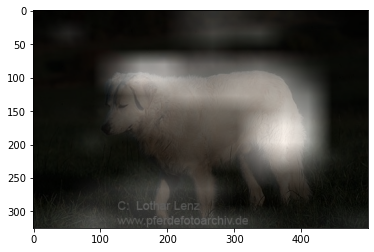

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block6_out', item)
plt.imshow(grad_cam_image)
plt.show()
blended_image = visualize_cam_on_image(grad_cam_image, item, alpha=0.8)
plt.imshow(blended_image)
plt.show()

Model input: (1, 224, 224, 3)
Model output: (1, 14, 14, 1024) (1, 120)
Weights: (1024,)
CAM: (14, 14)


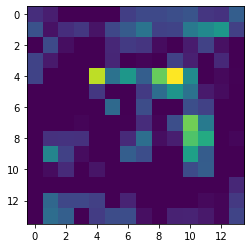

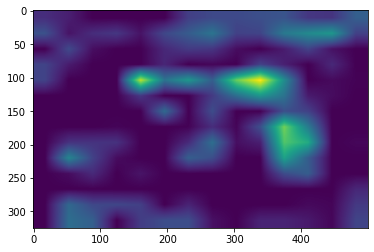

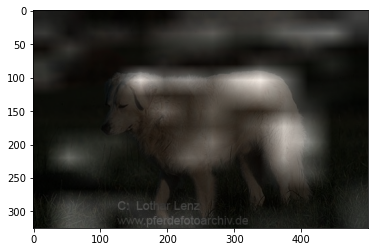

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()
blended_image = visualize_cam_on_image(grad_cam_image, item, alpha=0.8)
plt.imshow(blended_image)
plt.show()

## 3. Detection with CAM

In [25]:
'''
(1)바운딩 박스 구하기
'''
def get_bbox(cam_image, score_thresh=0.2):
    # th 이하 0으로 날리기
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    # cv2.findContours로 bbox 얻기
    '''
    cv2.findContours()        : 값이 동일한 등고선 그리기
    cv2.RETR_TREE             : 등고선을 계층적으로 구성하는 옵션
        > contours[0]         : 가장 바깥쪽 등고선
    cv2.CHAIN_APPROX_SIMPLE   : contours line을 그릴 수 있는 최소 point만 저장 
    cv2.minAreaRect(cnt)      : 회전 고려, 가장 작은 bbox 얻기(x,y,w,h,각도)
    cv2.boxPoints             : bbox 꼭지점 얻기
    '''
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect) #정수로 변환
    return rect

rect = get_bbox(cam_image)
print(rect)

[[ 50 238]
 [ 57  73]
 [435  91]
 [427 256]]


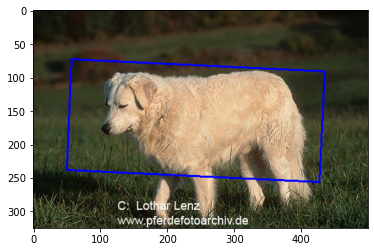

In [26]:
#cv2.drawContours로 bbox 그리기
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

pred_bbox(green): [73, 50, 256, 435]
real_bbox(red): [88, 100, 324, 418]
IOU: 0.5767439119002538


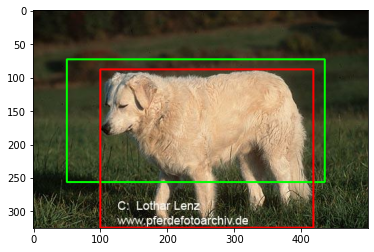

In [72]:
'''
(2)IOU 구하기
'''
from PIL import ImageDraw
image = copy.deepcopy(item['image'])
y_size, x_size= image.shape[0],image.shape[1]

#예측한 bbox 형태변환(tfds.features.BBoxFeature:[ymin, xmin, ymax, xmax])
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(y_size),  #bounding box의 y_min
        rect[:,0].min()/float(x_size),  #bounding box의 x_min
        rect[:,1].max()/float(y_size), #bounding box의 y_max
        rect[:,0].max()/float(x_size) #bounding box의 x_max
    ]
    return bbox

pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox_int = [rect[:,1].min(),rect[:,0].min(),rect[:,1].max(),rect[:,0].max()]

print('pred_bbox(green):',pred_bbox_int)

#실제 데이터의 bbox 가져오기
real_bbox=item['objects']['bbox'][0]
real_bbox_int = [int(real_bbox[0]*y_size),int(real_bbox[1]*x_size),int(real_bbox[2]*y_size),int(real_bbox[3]*x_size)]
print('real_bbox(red):',real_bbox_int)

#IOU 계산
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

item_iou=get_iou(pred_bbox, real_bbox)
print('IOU:',item_iou)

# bbox 비교
image = copy.deepcopy(item['image'])
cv2.rectangle(image, (pred_bbox_int[1], pred_bbox_int[0]), (pred_bbox_int[3], pred_bbox_int[2]), (0, 255, 0), 2)
cv2.rectangle(image, (real_bbox_int[1], real_bbox_int[0]), (real_bbox_int[3], real_bbox_int[2]), (255, 0, 0), 2)
plt.imshow(image)
plt.show()

- tfds.features.BBoxFeature:   
tf.Tensor of type tf.float32 and shape [4,] which contains the normalized coordinates of the bounding box [ymin, xmin, ymax, xmax]

### Reference
1. CAM, GAP   
    Zhou, Bolei, et al. "Learning deep features for discriminative localization.". 2016.
    https://joungheekim.github.io/2020/09/29/paper-review/
2. Grad-CAM   
    https://velog.io/@tobigs_xai/CAM-Grad-CAM-Grad-CAMpp
3. cv2.findContours()   
    https://opencv-python.readthedocs.io/en/latest/doc/15.imageContours/imageContours.html